In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
X, y = load_breast_cancer(True)

In [4]:
from sklearn.decomposition import PCA

In [5]:
pca = PCA()
X_pca = pca.fit_transform(X)

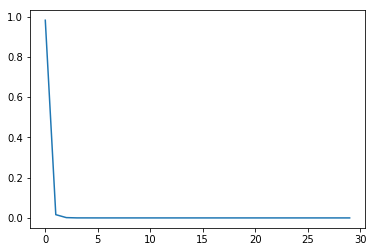

In [6]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [53]:
X_new = X_pca[:, :2]
_, D = X_new.shape

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=.3, random_state=10)

In [56]:
with pm.Model() as gpm:    
    ls = pm.Gamma("ls", 3, 1, shape=D)
    noise = pm.Gamma("noise", 3, 1)
        
    mu = pm.gp.mean.Zero()
    cov = pm.gp.cov.ExpQuad(input_dim=D, ls = ls)
    gp = pm.gp.Marginal(mean_func = mu, cov_func = cov)

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=noise)

Model fitting. 

In [57]:
with gpm:
    mp = pm.find_MAP()

logp = -242.43, ||grad|| = 0.0039048: 100%|██████████| 43/43 [00:01<00:00, 24.62it/s]  


In [58]:
for k, v in mp.items():
    print(k, ":", v)

ls_log__ : [ 3.52630103  2.7364165 ]
noise_log__ : -1.8852132910082682
ls : [ 33.9979772   15.43158682]
noise : 0.1517966791095988


Here we predict classes for new inputs.

In [59]:
n = 200
X0g, X1g = np.meshgrid(np.linspace(min(X_new[:,0]), max(X_new[:,0]), n), 
                       np.linspace(min(X_new[:,1]), max(X_new[:,1]), n))
X_grid = np.array([(x0, x1) for x0, x1 in zip(X0g.flatten(), X1g.flatten())])

In [60]:
mu_pred, var_pred = gp.predict(Xnew=X_test, point=mp, diag=True)
mu_grid, var_grid = gp.predict(Xnew=X_grid, point=mp, diag=True)

This shows the decision boundaries that the classifier has generated.

In [61]:
y_pred = np.round(mu_pred)
acc = np.sum(y_pred == y_test)/len(y_pred)
print(acc)

0.929824561404


In [62]:
dec_boundary = np.logical_and((mu_grid-.5)**2 < .15, True)

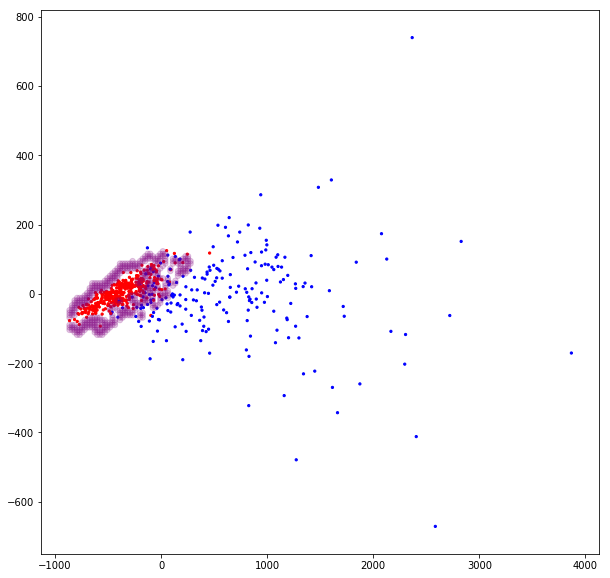

In [63]:
plt.figure(figsize=(10,10))
plt.scatter(X_new[:,0], X_new[:,1], c=["blue" if yi == 0 else "red" for yi in y], s=5, label="Dataset")
plt.scatter(X_grid[:,0], X_grid[:,1], c=["purple" if d else "none" for d in dec_boundary], s=30, alpha=.2, label="Decision Boundary")
plt.show()